In [1]:
import sys
import os
import logging

# Add the root directory to sys.path
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

# Ensure the logging directory exists
tmp_dir = os.path.join(root_dir, 'tmp')
os.makedirs(tmp_dir, exist_ok=True)

log_file = os.path.join(tmp_dir, 'tweets_loading.log')
logging.basicConfig(filename=log_file, level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)s %(name)s %(message)s')
logger=logging.getLogger(__name__)

In [8]:
import mysql.connector
from config import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
connection = mysql.connector.connect(host='localhost', user='root', password=config.get('PASSWORD'),database='jbg030', allow_local_infile=True)
cursor = connection.cursor()

In [15]:
query = """SELECT text, user_id, mentioned_airlines, user_mentions, label, timestamp_ms, baggage, money, staff, delay_and_cancellation
            FROM tweets
            WHERE timestamp_ms > 1500000000000 AND ((
                tweets.mentioned_airlines LIKE '%AirFrance%'
                OR tweets.mentioned_airlines LIKE '%Lufthansa%'
                OR tweets.mentioned_airlines LIKE '%KLM%'
                OR tweets.mentioned_airlines LIKE '%British Airways%'
            )
            OR (
                tweets.user_mentions LIKE '%106062176%'
                OR tweets.user_mentions LIKE '%124476322%'
                OR tweets.user_mentions LIKE '%56377143%'
                OR tweets.user_mentions LIKE '%18332190%'
            ))"""
cursor.execute(query)
texts = cursor.fetchall()
print("Text fetched.")
number_tweets = cursor.rowcount
print("Total number of rows in table: ", number_tweets)

Text fetched.
Total number of rows in table:  632264


In [18]:
df = pd.DataFrame(texts, columns=['text', 'user_id', 'mentioned_airlines', 'user_mentions', 'label', 'timestamp', 'baggage', 'money', 'staff', 'delay_and_cancellation'])

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms') # Convert the timestamp to datetime
df['hour'] = df['timestamp'].dt.hour
df['day_of_month'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

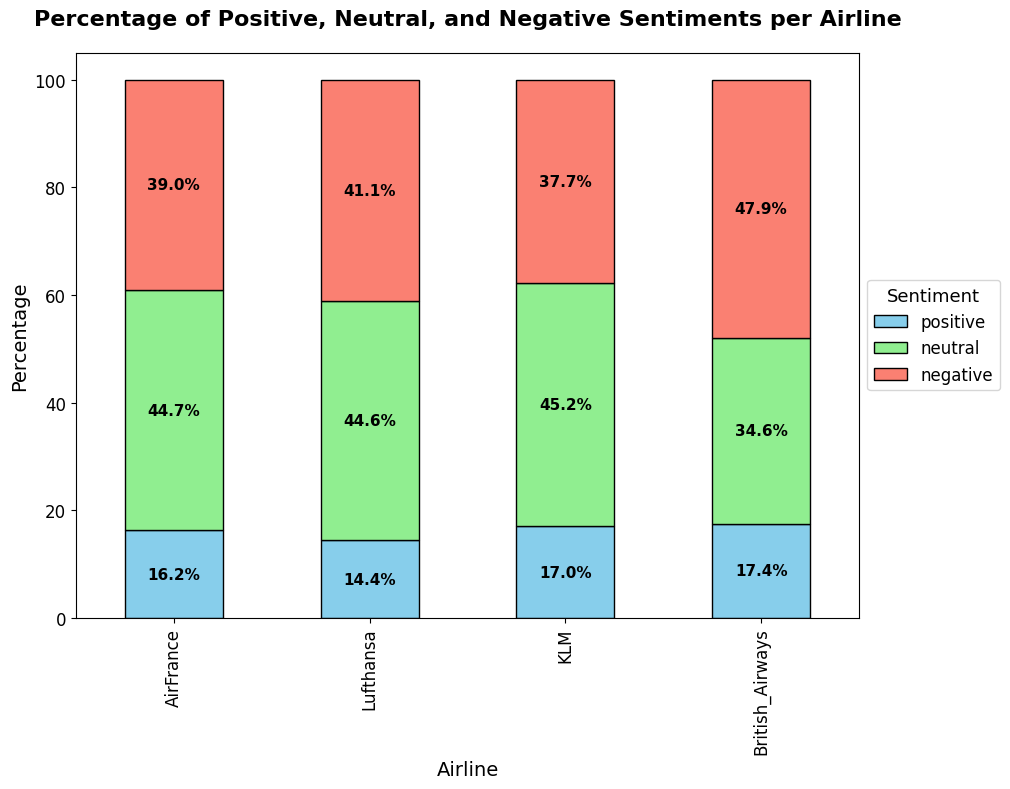

In [49]:
df['AirFrance'] = df['mentioned_airlines'].apply(lambda x: 'AirFrance' in x) | df['user_mentions'].apply(lambda x: '106062176' in x)
df['Lufthansa'] = df['mentioned_airlines'].apply(lambda x: 'Lufthansa' in x) | df['user_mentions'].apply(lambda x: '124476322' in x)
df['KLM'] = df['mentioned_airlines'].apply(lambda x: 'KLM' in x) | df['user_mentions'].apply(lambda x: '56377143' in x)
df['British_Airways'] = df['mentioned_airlines'].apply(lambda x: 'British_Airways' in x) | df['user_mentions'].apply(lambda x: '18332190' in x)

airlines = ['AirFrance', 'Lufthansa', 'KLM', 'British_Airways']
sentiments = ['positive', 'neutral', 'negative']

data = []
for airline in airlines:
    sentiment_counts = []
    for sentiment in sentiments:
        count = df[df[airline] & (df['label'] == sentiment)].shape[0]
        sentiment_counts.append(count)
    total = sum(sentiment_counts)
    percentages = [(count / total) * 100 if total > 0 else 0 for count in sentiment_counts]
    data.append(percentages)

plot_df = pd.DataFrame(data, columns=sentiments, index=airlines)

fig, ax = plt.subplots(figsize=(12, 8))

# Create the stacked bar plot
plot_df.plot(kind='bar', stacked=True, color=['skyblue', 'lightgreen', 'salmon'], ax=ax, edgecolor='black')

for i, airline in enumerate(airlines):
    pos_base = 0
    neu_base = plot_df.loc[airline, 'positive']
    neg_base = plot_df.loc[airline, 'positive'] + plot_df.loc[airline, 'neutral']
    for sentiment in sentiments:
        count = plot_df.loc[airline, sentiment]
        percentage = f"{count:.1f}%"
        if sentiment == 'positive':
            ax.text(i, pos_base + count / 2, percentage, ha='center', va='center', fontsize=11, weight='bold', color='black')
            pos_base += count
        elif sentiment == 'neutral':
            ax.text(i, neu_base + count / 2, percentage, ha='center', va='center', fontsize=11, weight='bold', color='black')
            neu_base += count
        else:
            ax.text(i, neg_base + count / 2, percentage, ha='center', va='center', fontsize=11, weight='bold', color='black')
            neg_base += count

            
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('Airline', fontsize=14)
ax.set_title('Percentage of Positive, Neutral, and Negative Sentiments per Airline', fontsize=16, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title='Sentiment', fontsize=12, title_fontsize='13', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

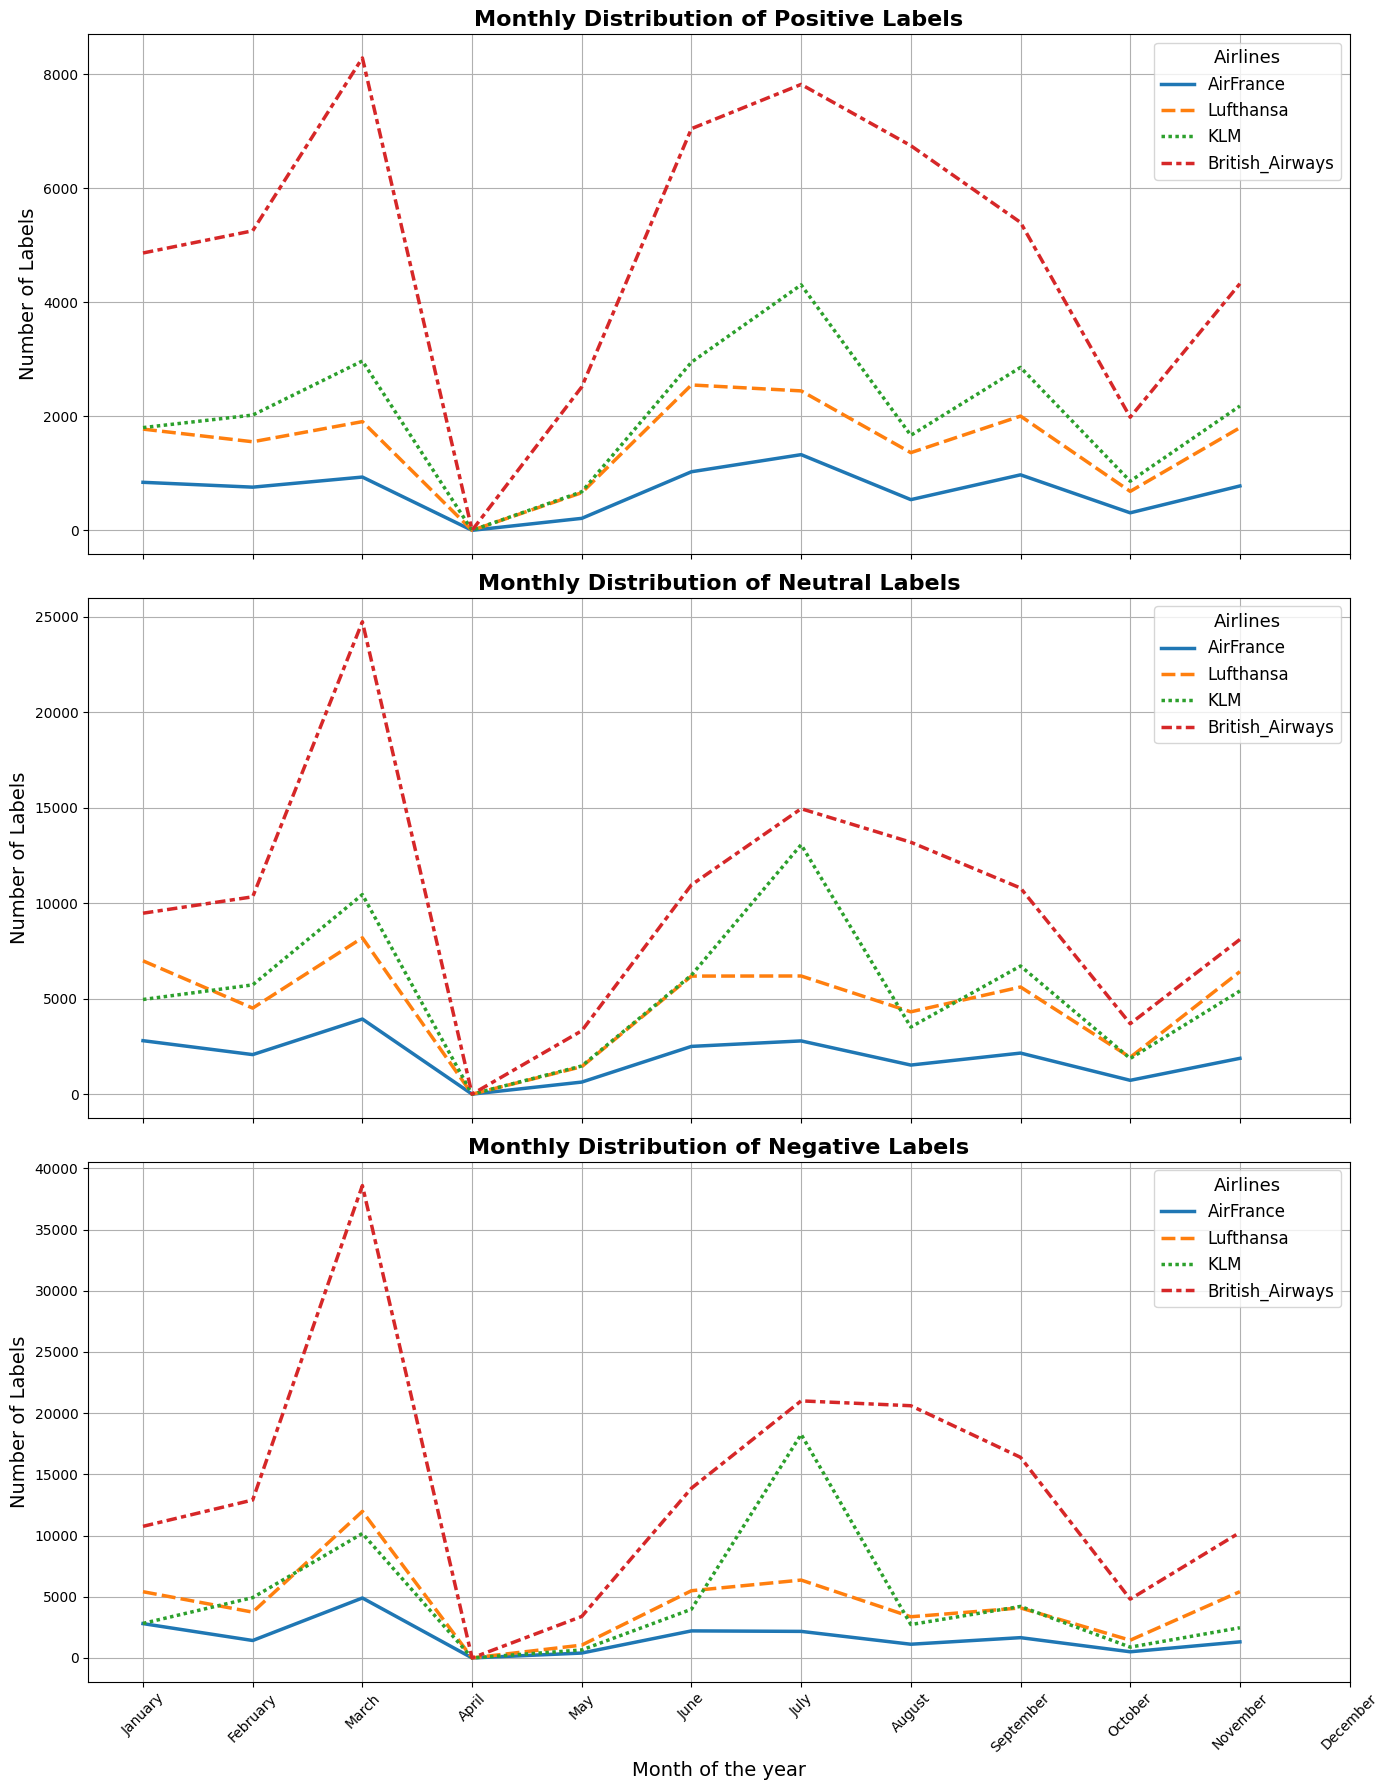

In [60]:
df['AirFrance'] = df['mentioned_airlines'].apply(lambda x: 'AirFrance' in x) | df['user_mentions'].apply(lambda x: '106062176' in x)
df['Lufthansa'] = df['mentioned_airlines'].apply(lambda x: 'Lufthansa' in x) | df['user_mentions'].apply(lambda x: '124476322' in x)
df['KLM'] = df['mentioned_airlines'].apply(lambda x: 'KLM' in x) | df['user_mentions'].apply(lambda x: '56377143' in x)
df['British_Airways'] = df['mentioned_airlines'].apply(lambda x: 'British_Airways' in x) | df['user_mentions'].apply(lambda x: '18332190' in x)

airlines = ['AirFrance', 'Lufthansa', 'KLM', 'British_Airways']
sentiments = ['positive', 'neutral', 'negative']

monthly_counts = {sentiment: {airline: [] for airline in airlines} for sentiment in sentiments}

for sentiment in sentiments:
    for airline in airlines:
        monthly_count = df[df[airline] & (df['label'] == sentiment)].groupby('month').size().reindex(range(1, 12), fill_value=0)
        monthly_counts[sentiment][airline] = monthly_count

df_positive = pd.DataFrame(monthly_counts['positive'])
df_neutral = pd.DataFrame(monthly_counts['neutral'])
df_negative = pd.DataFrame(monthly_counts['negative'])

fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

sns.lineplot(data=df_positive, linewidth=2.5, ax=axs[0])
axs[0].set_title('Monthly Distribution of Positive Labels', fontsize=16, weight='bold')
axs[0].set_ylabel('Number of Labels', fontsize=14)
axs[0].legend(title='Airlines', fontsize=12, title_fontsize='13', loc='upper right')
axs[0].grid(True)

sns.lineplot(data=df_neutral, linewidth=2.5, ax=axs[1])
axs[1].set_title('Monthly Distribution of Neutral Labels', fontsize=16, weight='bold')
axs[1].set_ylabel('Number of Labels', fontsize=14)
axs[1].legend(title='Airlines', fontsize=12, title_fontsize='13', loc='upper right')
axs[1].grid(True)

sns.lineplot(data=df_negative, linewidth=2.5, ax=axs[2])
axs[2].set_title('Monthly Distribution of Negative Labels', fontsize=16, weight='bold')
axs[2].set_ylabel('Number of Labels', fontsize=14)
axs[2].legend(title='Airlines', fontsize=12, title_fontsize='13', loc='upper right')
axs[2].grid(True)

axs[2].set_xlabel('Month of the year', fontsize=14)
axs[2].set_xticks(range(1, 13))
axs[2].set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)

plt.tight_layout()
plt.show()


/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/2656761560.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues')


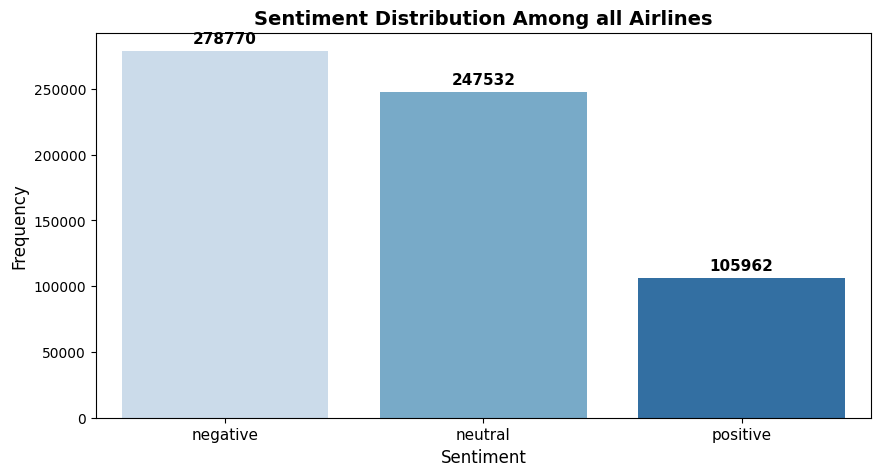

In [35]:
sentiment_counts = df['label'].value_counts()

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues')

plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Sentiment Distribution Among all Airlines', fontsize=14, weight='bold')
plt.xticks(fontsize=11)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, weight='bold', color='black')

plt.show()

/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4185868438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4185868438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4185868438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent

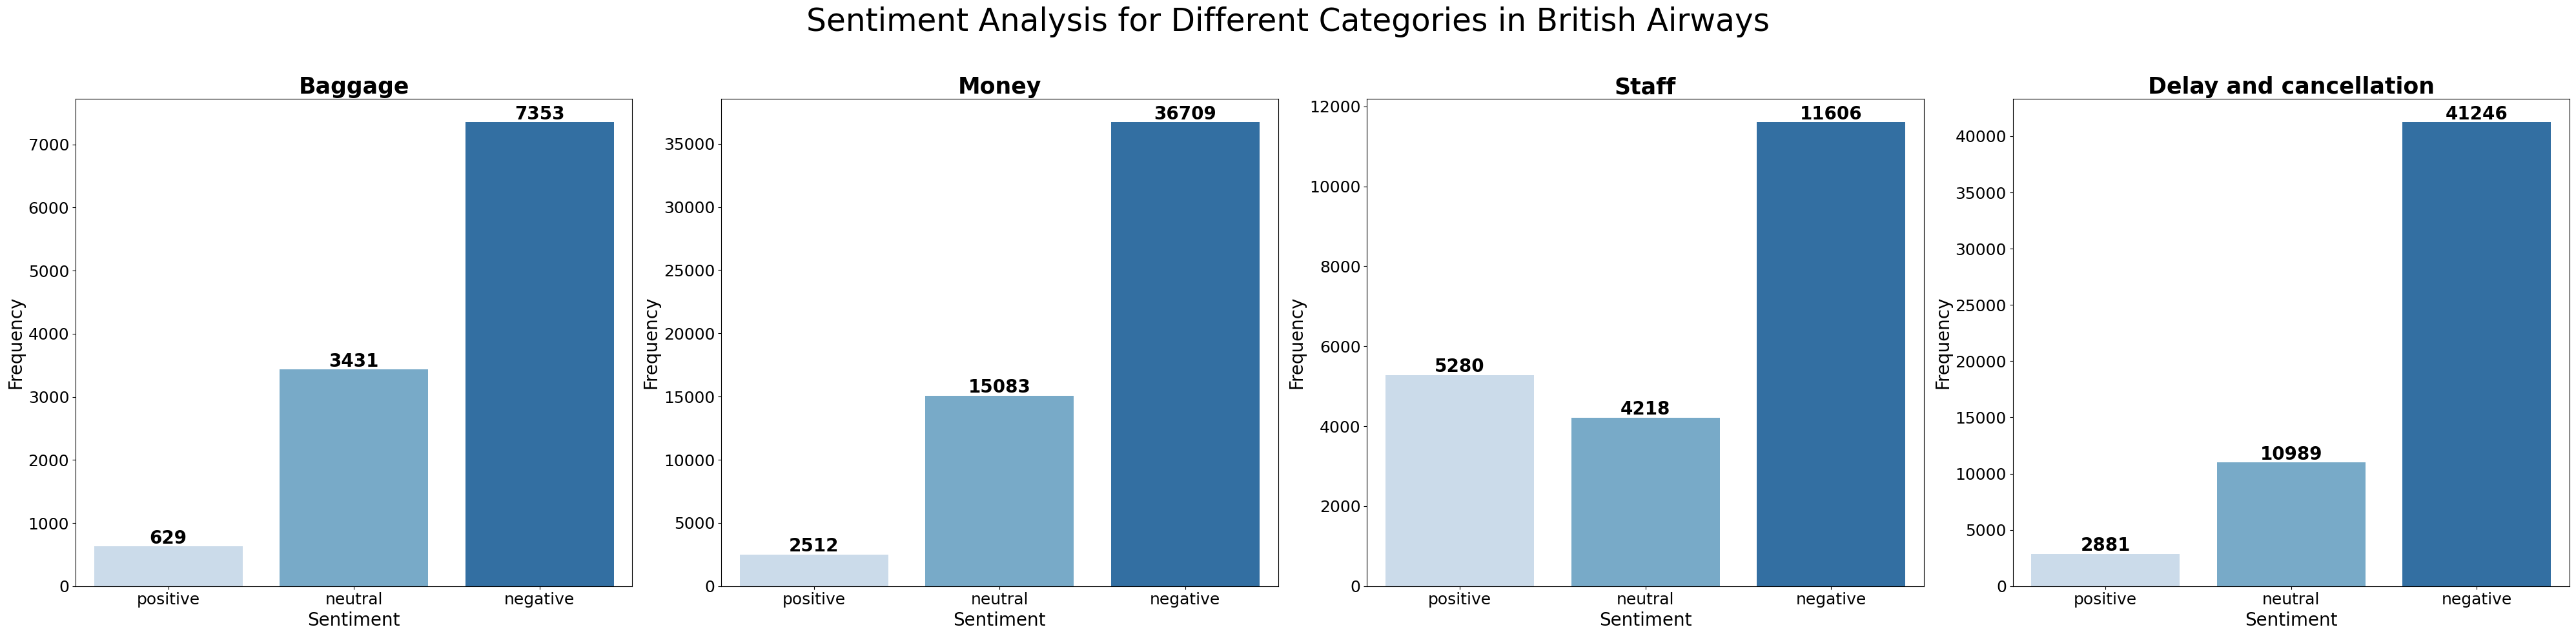

In [31]:
df_ba = df[df['mentioned_airlines'].apply(lambda x: 'British_Airways' in x) | df['user_mentions'].apply(lambda x: '18332190' in x)]

# Plot settings
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Sentiment Analysis for Different Categories in British Airways', fontsize=35)

categories = ['baggage', 'money', 'staff', 'delay_and_cancellation']
sentiments = ['positive', 'neutral', 'negative']

for ax, category in zip(axs.flatten(), categories):
    category_data = df_ba[df_ba[category] == 1]
    
    sentiment_counts = category_data['label'].value_counts().reindex(sentiments, fill_value=0)
    
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=20, weight='bold', color='black')
    
    ax.set_title(category.capitalize().replace('_', ' '), fontsize=25, weight='bold')
    ax.set_xlabel('Sentiment', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/3581145005.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/3581145005.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/3581145005.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent

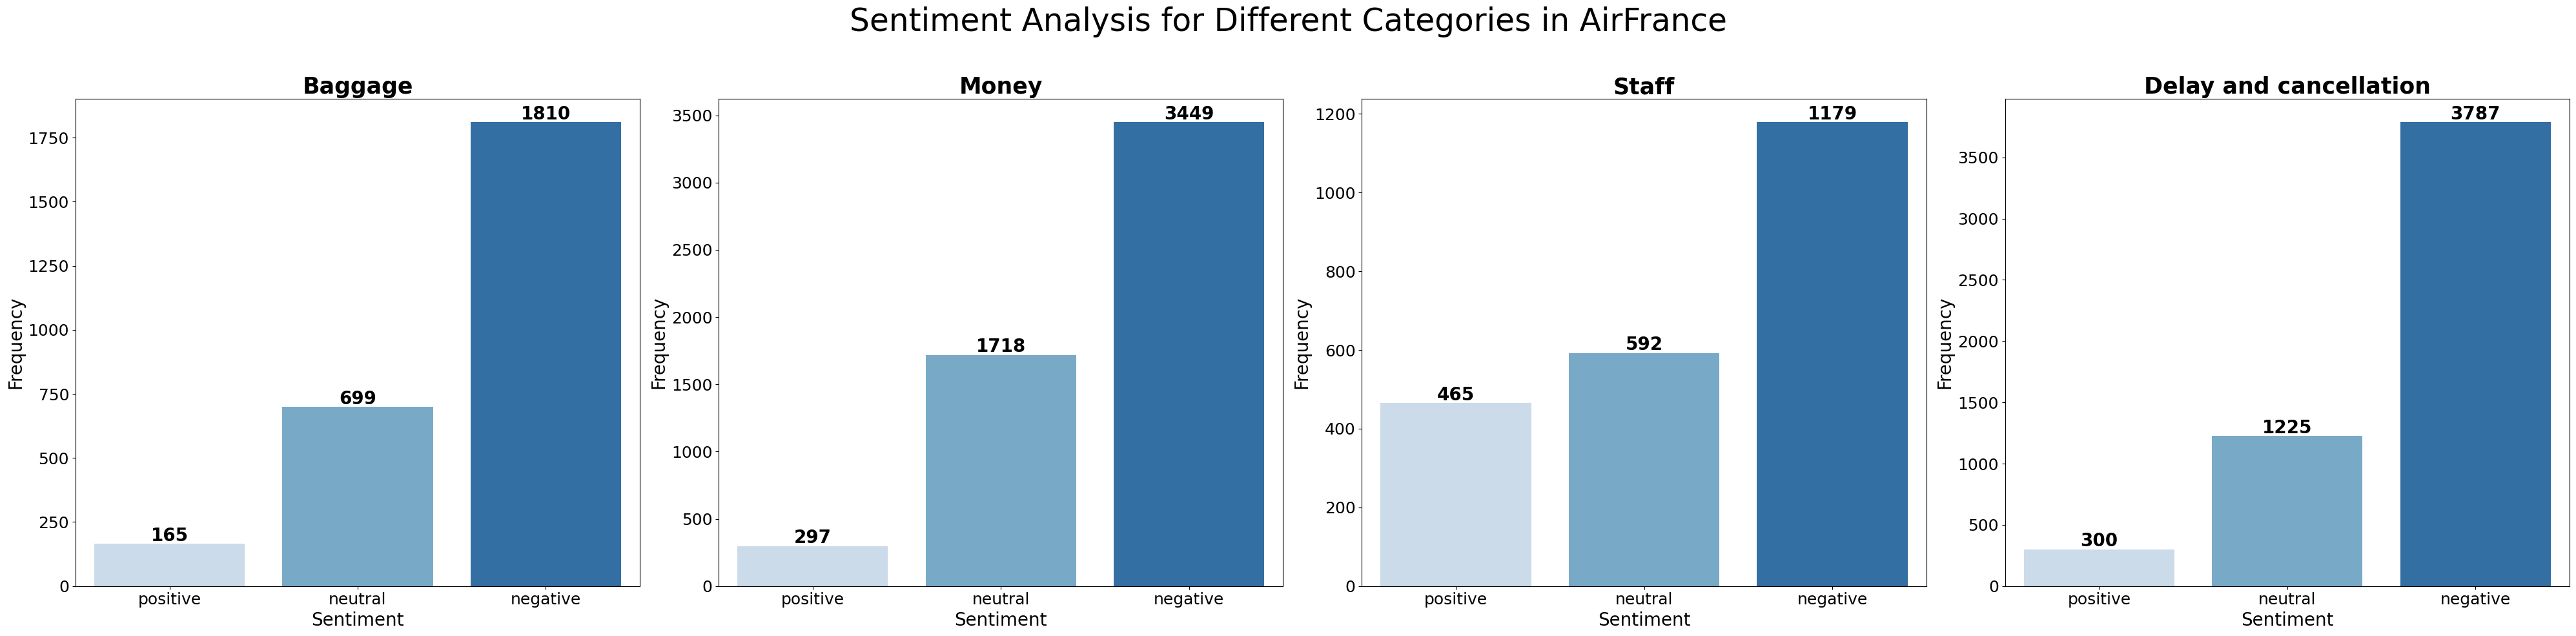

In [27]:
df_ba = df[df['mentioned_airlines'].apply(lambda x: 'AirFrance' in x) | df['user_mentions'].apply(lambda x: '106062176' in x)]

# Plot settings
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Sentiment Analysis for Different Categories in AirFrance', fontsize=35)

categories = ['baggage', 'money', 'staff', 'delay_and_cancellation']
sentiments = ['positive', 'neutral', 'negative']

for ax, category in zip(axs.flatten(), categories):
    category_data = df_ba[df_ba[category] == 1]
    
    sentiment_counts = category_data['label'].value_counts().reindex(sentiments, fill_value=0)
    
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=20, weight='bold', color='black')
    
    ax.set_title(category.capitalize().replace('_', ' '), fontsize=25, weight='bold')
    ax.set_xlabel('Sentiment', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4005862587.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4005862587.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/4005862587.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent

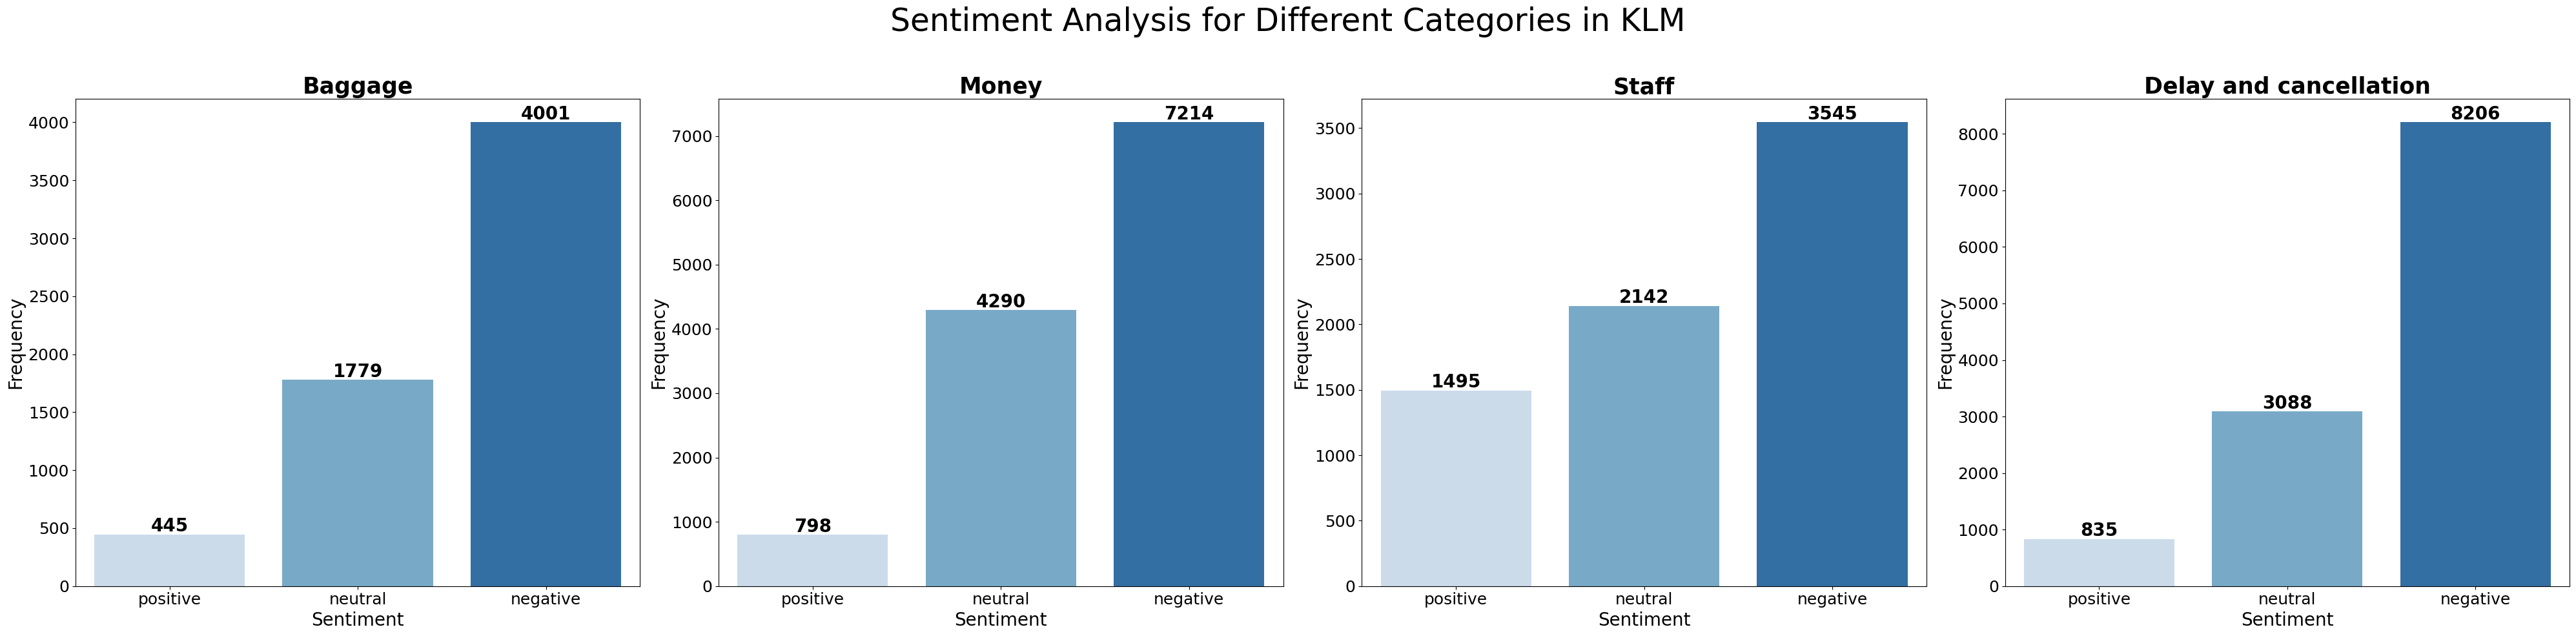

In [28]:
df_ba = df[df['mentioned_airlines'].apply(lambda x: 'KLM' in x) | df['user_mentions'].apply(lambda x: '56377143' in x)]

# Plot settings
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Sentiment Analysis for Different Categories in KLM', fontsize=35)

categories = ['baggage', 'money', 'staff', 'delay_and_cancellation']
sentiments = ['positive', 'neutral', 'negative']

for ax, category in zip(axs.flatten(), categories):
    category_data = df_ba[df_ba[category] == 1]
    
    sentiment_counts = category_data['label'].value_counts().reindex(sentiments, fill_value=0)
    
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=20, weight='bold', color='black')
    
    ax.set_title(category.capitalize().replace('_', ' '), fontsize=25, weight='bold')
    ax.set_xlabel('Sentiment', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/1780128072.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/1780128072.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
/var/folders/j7/5c4q135n1d7848nc4qdb9q5h0000gn/T/ipykernel_51188/1780128072.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent

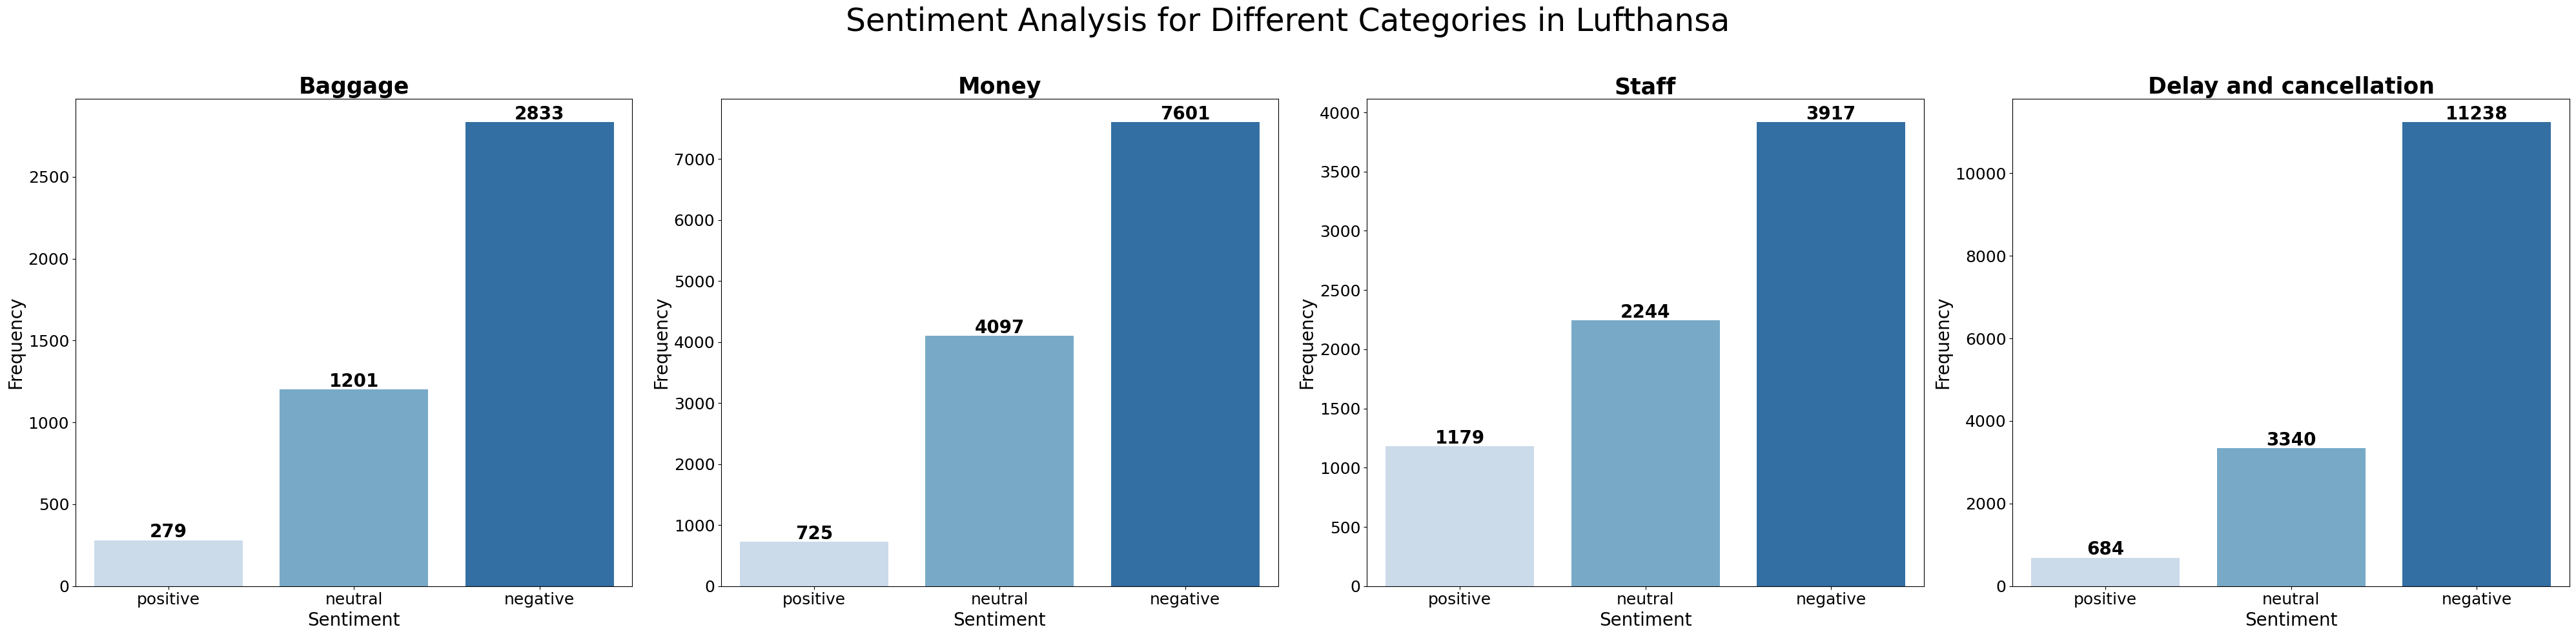

In [29]:
df_ba = df[df['mentioned_airlines'].apply(lambda x: 'Lufthansa' in x) | df['user_mentions'].apply(lambda x: '124476322' in x)]

# Plot settings
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle('Sentiment Analysis for Different Categories in Lufthansa', fontsize=35)

categories = ['baggage', 'money', 'staff', 'delay_and_cancellation']
sentiments = ['positive', 'neutral', 'negative']

for ax, category in zip(axs.flatten(), categories):
    category_data = df_ba[df_ba[category] == 1]
    
    sentiment_counts = category_data['label'].value_counts().reindex(sentiments, fill_value=0)
    
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Blues', ax=ax)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=20, weight='bold', color='black')
    
    ax.set_title(category.capitalize().replace('_', ' '), fontsize=25, weight='bold')
    ax.set_xlabel('Sentiment', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()